In [139]:
# -*- coding:utf-8 -*-
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import array_to_img
import cv2
from data import *


class myUnet(object):
    def __init__(self, img_rows=512, img_cols=512):
        self.img_rows = img_rows
        self.img_cols = img_cols

    def load_data(self):
        mydata = dataProcess(self.img_rows, self.img_cols)
        imgs_train, imgs_mask_train = mydata.load_train_data()
        imgs_test = mydata.load_test_data()
        return imgs_train, imgs_mask_train, imgs_test

    def get_unet(self):
        inputs = Input((self.img_rows, self.img_cols, 3))

        conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
        conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
        conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
        conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
        conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
        drop5 = Dropout(0.5)(conv5)

        up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
            UpSampling2D(size=(2, 2))(drop5))
        merge6 = concatenate([drop4, up6], axis=3)
        conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
        conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

        up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
            UpSampling2D(size=(2, 2))(conv6))
        merge7 = concatenate([conv3, up7], axis=3)
        conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
        conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

        up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
            UpSampling2D(size=(2, 2))(conv7))
        merge8 = concatenate([conv2, up8], axis=3)
        conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
        conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

        up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
            UpSampling2D(size=(2, 2))(conv8))
        merge9 = concatenate([conv1, up9], axis=3)
        conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
        conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

        conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
        model = Model(input=inputs, output=conv10)

        model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

        return model

    def train(self):
       # print("loading data")
        imgs_train, imgs_mask_train, imgs_test = self.load_data()
        print(imgs_train.shape)
       # print("loading data done")
        model = self.get_unet()
       # print("got unet")
        model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', verbose=1, save_best_only=True)
       # print('Fitting model...')
        model.fit(imgs_train, imgs_mask_train, batch_size=2, epochs=1, verbose=1,
                  validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

        print('predict test data')
        imgs_mask_test = model.predict(imgs_test, batch_size=1, verbose=1)
        np.save('./results/imgs_mask_test.npy', imgs_mask_test)

    def save_img(self):
        print("array to image")
        imgs = np.load('./results/imgs_mask_test.npy')
        piclist = []
        for line in open("./results/pic.txt"):
            line = line.strip()
            picname = line.split('/')[-1]
            piclist.append(picname)
        for i in range(imgs.shape[0]):
            path = "./results/" + piclist[i]
            img = imgs[i]
            img = array_to_img(img)
            
            img.save(path)
            cv_pic = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            cv_pic = cv2.resize(cv_pic,(512,512),interpolation=cv2.INTER_CUBIC)
            binary, cv_save = cv2.threshold(cv_pic, 127, 255, cv2.THRESH_BINARY)
            
            cv2.imwrite(path, cv_save)


if __name__ == '__main__':
    myunet = myUnet()
    model = myunet.get_unet()
    # model.summary()
    # plot_model(model, to_file='model.png')
    myunet.train()
    myunet.save_img()


W0630 16:53:52.411476  6772 deprecation_wrapper.py:119] From D:\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0630 16:53:52.605342  6772 deprecation_wrapper.py:119] From D:\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 16:53:52.643939  6772 deprecation_wrapper.py:119] From D:\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0630 16:53:52.712427  6772 deprecation_wrapper.py:119] From D:\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0630 16:53:52.791382  6772 deprecation_wrapper.py:119] From D:\Anaconda\lib\site-packages\keras\backend\tensorflow_back

load train images...
(17, 512, 512, 3)
------------------------------
load test images...
------------------------------
(17, 512, 512, 3)
Train on 13 samples, validate on 4 samples
Epoch 1/1
13/13 [==============================] - 229s 18s/step - loss: 0.6663 - acc: 0.8211 - val_loss: 0.4637 - val_acc: 0.7861

Epoch 00001: loss improved from inf to 0.66635, saving model to unet.hdf5
predict test data
10/10 [==============================] - 26s 3s/step
array to image


In [42]:
import io
from PIL import Image
myunet = myUnet()
myunet.save_img()

array to image
<PIL.Image.Image image mode=RGB size=512x512 at 0x1C33429EC88>
191 191 191
<PIL.Image.Image image mode=RGB size=512x512 at 0x1C33429E630>
191 191 191
<PIL.Image.Image image mode=RGB size=512x512 at 0x1C33429EBE0>
191 191 191
<PIL.Image.Image image mode=RGB size=512x512 at 0x1C33429E358>
193 193 193
<PIL.Image.Image image mode=RGB size=512x512 at 0x1C33429E8D0>
188 188 188
<PIL.Image.Image image mode=RGB size=512x512 at 0x1C33429E748>
193 193 193
<PIL.Image.Image image mode=RGB size=512x512 at 0x1C33429E518>
194 194 194
<PIL.Image.Image image mode=RGB size=512x512 at 0x1C33429EC88>
192 192 192
<PIL.Image.Image image mode=RGB size=512x512 at 0x1C33429E358>
191 191 191
<PIL.Image.Image image mode=RGB size=512x512 at 0x1C33429EBE0>
191 191 191


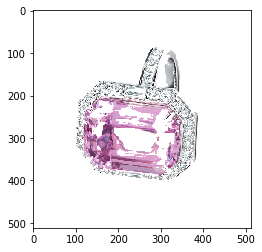

In [162]:
import cv2
imgs_test = np.load(npy_path + "/imgs_test.npy")
image=imgs_test[6]
#image=Image.open("./data/test/0.png")
#image=Image.open("./data/test/0.png")
#imgplot = plt.imshow(image)
import imageio
#im = scipy.misc.imread('./results/test/0.png', flatten=False, mode='RGB')
# img = imageio.imread('./results/test/0.png', pilmode='RGB')
# pixels = img.load()
# for i in range(img.shape[0]):    # for every col:
#     for j in range(img.shape[1]):    # For every row
#         pixels[i,j] = (i, j, 100)

i = Image.open("./results/test/6.png")
# print(i.size)
pixels = i.load() # this is not a list, nor is it list()'able
width, height = i.size
#imgplot = plt.imshow(i)

#rgb_im_old = image.convert('RGB')
rgb_im = i.convert('RGB')
#print(rgb_im_old.size)

new_img = Image.new("RGB", (512, 512))


cv_pic = cv2.imread("./results/test/6.png", cv2.IMREAD_GRAYSCALE)
cv_pic = cv2.resize(cv_pic,(512,512),interpolation=cv2.INTER_CUBIC)
binary, cv_save = cv2.threshold(cv_pic, 127, 255, cv2.THRESH_BINARY)

all_pixels = []
for x in range(width):
    for y in range(height):
        r_old=image[x][y][0]
        g_old=image[x][y][1]
        b_old =image[x][y][2]
        #= rgb_im_old.getpixel((x, y))
        r, g, b = rgb_im.getpixel((x, y))
        if(cv_save[x][y]==255):
            new_img.putpixel((x,y), (r_old, g_old, b_old))
        else:
             new_img.putpixel((x,y), (255, 255, 255))      
                
        
        #cpixel = pixels[x, y]
        #all_pixels.append(cpixel)
imgplot = plt.imshow(new_img)

# path = "./results/test"
new_img.save("./results/test/test.png")
# img = Image.new('RGB', (width, height))
# img.putdata(my_list)
# img.save('image.png')


In [136]:
npy_path="./npydata"
imgs_test = np.load(npy_path + "/imgs_test.npy")
#plt.imshow(imgs_test[0])
imgs_test[0].shape
image=imgs_test[0]
image.shape

(512, 512, 3)